# Power trace analysis #
For both power analysis 1 and power analysis 2 I will be using Correlation Power Analysis on some traces that I collect from the challenge instances, the script used to collect these traces can be found in another file `collect.py`. Each trace consists of two parts: the 16 byte plaintext that got processed, and the list of values corresponding to power measurements. The plaintexts are represented as hex so they should be converted back to bytes when running the attack. 


AES-128 uses a 16 byte key, to retrieve this key we will focus on a byte of the key at a time, called subkeys. Because each subkey is a byte, there are 256 possibilities for each subkey. For each of these possibilities we model the power that would be consumed if that possibility were the actual subkey. Then, we find the possibility that is most similar to the measured power trace. To carry this out, we need to find a part of the AES-128 algorithm to model, typically this will be the first sub-bytes operation. Here, the algorithm acts on every byte of the plaintext and the key. Every byte of the plaintext is xorred with the corresponding subkey and this value used to index into the sbox, lets call this result *v*. The power consumed will depend on the value of *v*. In this case, I use the hamming weight of *v* because the hint says that the power consumed is related to hamming weight. Call this *h*. For every subkey there will be 256 different possibilities we can guess for it. The vector of possibilities `{0, 1, 2, 3, ... 0xff}` is called **K**. Therefore there will also be 256 different possibilities of *v* for one plaintext and thus 256 different possibilites of *h*. We can do this multiple times on every plaintext we collected to get the matrix **V** and **H**. The *k*th column in **V** contains *k* xored with the *k*th byte of *p* for every *p* in the collected plaintext. The matrix **H** is the predicted power consumed for that column. Therefore, we can compare every column in **H** against all power traces and see which column is most similar to the power trace. To test for similarity, we will use Pearson's Correlation Coefficient. Now we can move on and start examining the data.




For futher reading, [Running Correlation Power Analysis](https://cryptography.gmu.edu/documentation/fobos/cpa.html) and [Power analysis attacks on the AES-128 S-box using differential power analysis (DPA) and correlation power analysis (CPA)](https://doi.org/10.1080/23742917.2016.1231523) detail CPA better then I ever could

In [6]:
#Make sure to set a port number!
import numpy as np
#this can be ignored if you collect the data some other way as the traces are stored elsewhere
from pwn import *
from matplotlib import pyplot as plt
PORT = 58966
DATAFILE = "traces.txt"

In [7]:
#sbustitution box used in AES, we will use it to get *v*
Sbox = [
	0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
	0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
	0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
	0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
	0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
	0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
	0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
	0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
	0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
	0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
	0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
	0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
	0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
	0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
	0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
	0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
]



In [8]:
#take 16 bytes of input and returns a list of numbers
#I won't collect traces because I already collected some earlier due to crappy internet
def sendInput(plainText):
    r = remote("saturn.picoctf.net", PORT)
    r.recvuntil(b"Please provide 16 bytes of plaintext encoded as hex: ")
    r.sendline(plainText.tobytes().hex())
    r.recvuntil(b"power measurement result: ")
    intermediate = ((r.recvline()).strip())[1:-1].split(b", ")
    res = [int(x.decode()) for x in intermediate]

    return res
    r.close()

In [9]:
#collect our first power trace
test = np.frombuffer(b"yellow submarine", dtype='uint8')
trace = sendInput(test)

[x] Opening connection to saturn.picoctf.net on port 58966
[x] Opening connection to saturn.picoctf.net on port 58966: Trying 13.59.203.175
[+] Opening connection to saturn.picoctf.net on port 58966: Done


/tmp/ipykernel_12428/937818215.py:6: BytesWarning: Text is not bytes; assuming ASCII, no guarantees. See https://docs.pwntools.com/#bytes
  r.sendline(plainText.tobytes().hex())


## Finding where sub bytes happen ##
The first steps that happen during AES is load keys and sub bytes, looking at the graph below there is a noticable jump in power consumption at point 3 (300 points into the algorithm). Power consumption is steady from point 3 to 4 before it starts changing a bunch. My guess is that the first 300 data points is the load keys operation, while points 300-400 is when sub bytes is happening.

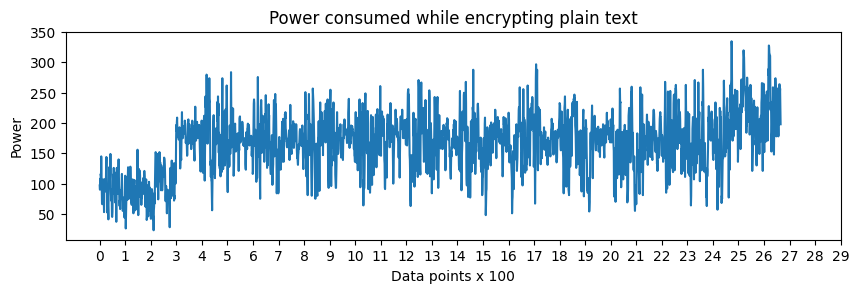

In [10]:
#graph the trace and save an image
fig, ax = plt.subplots(figsize=(10, 2.7))
ax.plot(trace)
ax.set_title("Power consumed while encrypting plain text")
ax.set_ylabel("Power")
ax.set_xlabel("Data points x 100")
ax.set_xticks(np.arange(0, 3000, 100), np.arange(0, 30, 1))

plt.savefig("powerTrace.png")
plt.show()

In [11]:
len(trace)

2666

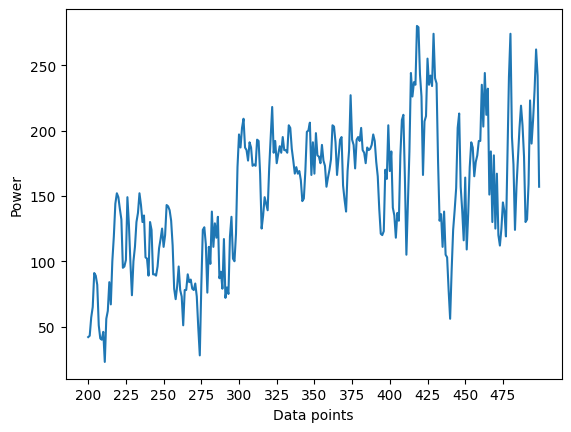

In [12]:
#notice the changes at point 300 and 400
fix, ax = plt.subplots()
ax.plot(trace[200:500])
ax.set_ylabel("Power")
ax.set_xlabel("Data points")
ax.set_xticks(np.arange(0, 300, 25), np.arange(200, 500, 25))

plt.savefig("subBytes.png")
plt.show()

Assumption is that based on the sudden jump in energy consumption around the 300th data point, that this is when first SubBytes starts

In [13]:
#now we will gather pre gathered traces, you can run ./collect.py [port] traces.txt to collect them
#the format is plaintext[data]\n for every trace
with open(DATAFILE, "r") as f:
    rawData = f.readlines()

In [14]:
len(rawData)

100

In [15]:
plain = rawData[0][:32]
plain

'449fd56fa872a9db2031c8590a79577c'

In [16]:
plainTexts = [bytes.fromhex(x[:32]) for x in rawData]

In [17]:
len(plainTexts[0])

16

In [18]:
traces = []
for x in rawData:
    strList = x[32:-1]
    values = [int(y) for y in strList[1:-1].split(", ")]
    traces.append(values)

In [19]:
len(traces[0])

2666

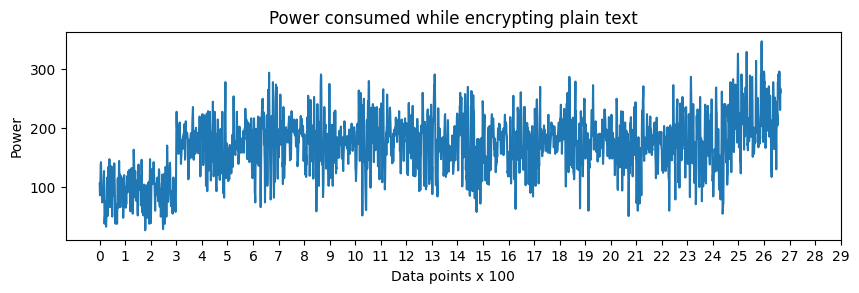

In [20]:
#look at some of the traces
fig, ax = plt.subplots(figsize=(10, 2.7))
ax.plot(traces[0])
ax.set_title("Power consumed while encrypting plain text")
ax.set_ylabel("Power")
ax.set_xlabel("Data points x 100")
ax.set_xticks(np.arange(0, 3000, 100), np.arange(0, 30, 1))

plt.show()

## Analysis Finally happening ##

In [21]:
#this is our hamming weight power model
def powerModel(x):
    return x.bit_count()

In [22]:
keyIndex = 0

In [23]:
#Every row corresponds to one plain text, where the columns represent an individual key candidate that processes all plaintexts
V = np.array(
    [[Sbox[plainText[keyIndex] ^ k] for k in range(256)] for plainText in plainTexts]
)

In [24]:
V.shape

(100, 256)

In [25]:
H = np.vectorize(powerModel)(V)

In [26]:
#This is where sub bytes should happen
T = np.array(traces)[:, 300:400]

In [27]:
#Input is vector of power model of one subkey applied to all plain texts, so it should be of length len(plainTexts) or len(traces)
def correlate(i):
    #One (or multiple) points in time is when the power consumption depends heavily on Sbox[plainText ^ subKey],
    #it is assumed to be somewhere between the time points 300 and 400 so just test all of these and take the one that
    #correlates the most to assume it is that point
    possibleSubBytes = T.T
    maxCorr = 0
    for point in possibleSubBytes:
        corr = (np.corrcoef(i, point)[0][1])
        maxCorr = max(maxCorr, corr)
    return maxCorr
    

In [28]:
#first test out stuff
correlate(H.T[0])

0.20857434576784906

In [29]:
results = [correlate(x) for x in H.T]

In [30]:
firstByteOfKey = np.argmax(results)

In [31]:
hex(firstByteOfKey)

'0x4c'

In [ ]:
#Find the key
key = []
for subKey in range(16):
    print(f"{subKey + 1} / 16 subKeys")
    #M = np.array([[Sbox[(plainText[subKey] ^ keyCandidate)] for keyCandidate in range(256)] for plainText in plainTexts])
    V = np.array(
        [[Sbox[plainText[subKey] ^ k] for k in range(256)] for plainText in plainTexts]
    )
    H = np.vectorize(powerModel)(V)
    results = [correlate(x) for x in H.T]
    correctKey = np.argmax(results)
    print(f"Subkey is {correctKey:x} with corrcoef {results[correctKey]}")
    key.append(correctKey)

1 / 16 subKeys
Subkey is 4c with corrcoef 0.6232678587345468
2 / 16 subKeys
Subkey is 0 with corrcoef 0.7132562006487503
3 / 16 subKeys
Subkey is 1a with corrcoef 0.5173067578163487
4 / 16 subKeys
Subkey is d4 with corrcoef 0.6547061249975092
5 / 16 subKeys
Subkey is c8 with corrcoef 0.5267532332338728
6 / 16 subKeys
Subkey is c1 with corrcoef 0.6253883173020379
7 / 16 subKeys
Subkey is d3 with corrcoef 0.6872778993465453
8 / 16 subKeys
Subkey is 54 with corrcoef 0.47546354206311897
9 / 16 subKeys
Subkey is b6 with corrcoef 0.6359471061435978
10 / 16 subKeys
Subkey is fb with corrcoef 0.6431473260432136
11 / 16 subKeys
Subkey is 5e with corrcoef 0.5627553396145903
12 / 16 subKeys
Subkey is 55 with corrcoef 0.5906483231200399
13 / 16 subKeys
Subkey is a3 with corrcoef 0.6748488415808515
14 / 16 subKeys
Subkey is c5 with corrcoef 0.5579756726401756
15 / 16 subKeys


In [93]:
key

[76, 0, 26, 212, 200, 193, 211, 84, 182, 251, 94, 85, 163, 197, 102, 210]

In [1]:
flag = ""
for num in key:
    x = int(num)
    flag += f'{x:2x}'

NameError: name 'key' is not defined

In [95]:
flag

'4c01ad4c8c1d354b6fb5e55a3c566d2'

# References #
[Running Correlation Power Analysis](https://cryptography.gmu.edu/documentation/fobos/cpa.html) <br>
[Power analysis attacks on the AES-128 S-box using differential power analysis (DPA) and correlation power analysis (CPA)](https://doi.org/10.1080/23742917.2016.1231523) <br>
[Writeup by ManhNgocNguyen](https://hackmd.io/@dxkfZ5P8RLCGOYGeqSzmVw/S1KxQmhln#Power-Analysis-Part-1)